In [1]:
import pandas as pd
import numpy as np
import acbm
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely import wkt

from typing import Optional, Tuple


# Read in the data 

In [2]:
# NTS data 
legs_nts = pd.read_parquet(
    acbm.root_path / "data/external/nts/filtered/nts_trips.parquet"
)

legs_nts = legs_nts[legs_nts["TravDay"] == 3]

# Model outputs 
legs_acbm = pd.read_csv(
    acbm.root_path / "data/processed/activities_pam/legs.csv"
)
legs_acbm_geo = pd.read_parquet(
    acbm.root_path / "data/processed/activities_pam/legs_with_locations.parquet"
)



In [3]:
legs_acbm


,Unnamed: 0,pid,hid,freq,ozone,dzone,purp,origin activity,destination activity,mode,seq,tst,tet,duration
0,0,200,89,NaN,E00059031,E00058877,work,home,work,car,1.0,1900-01-01 12:30:00,1900-01-01 13:00:00,0:30:00
1,1,200,89,NaN,E00059031,E00059031,home,work,home,car,2.0,1900-01-01 16:30:00,1900-01-01 17:00:00,0:30:00
2,2,312,139,NaN,E00059045,E00057153,escort,home,escort,car,1.0,1900-01-01 06:35:00,1900-01-01 06:54:00,0:19:00
3,3,312,139,NaN,E00057153,E00169797,work,escort,work,car,2.0,1900-01-01 06:55:00,1900-01-01 07:22:00,0:27:00
4,4,312,139,NaN,E00059045,E00059045,home,work,home,car,3.0,1900-01-01 18:00:00,1900-01-01 18:35:00,0:35:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15098,15098,794027,334502,NaN,E00057268,E00057826,home,visit,home,car,4.0,1900-01-01 22:30:00,1900-01-01 22:50:00,0:20:00
15099,15099,794272,334647,NaN,E00170040,E00058459,shop,home,shop,car,1.0,1900-01-01 08:50:00,1900-01-01 09:00:00,0:10:00
15100,15100,794272,334647,NaN,E00058459,E00170040,home,shop,home,car,2.0,1900-01-01 10:20:00,1900-01-01 10:30:00,0:10:00
15101,15101,794273,334647,NaN,E00170040,E00057187,shop,home,shop,car,1.0,1900-01-01 08:50:00,1900-01-01 09:00:00,0:10:00


### Preprocess: Rename columns

In [4]:
# rename origin activity and destination activity columns

legs_acbm = legs_acbm.rename(columns={"origin activity": "oact", "destination activity": "dact"})
legs_acbm_geo = legs_acbm_geo.rename(columns={"origin activity": "oact", "destination activity": "dact"})


# rename distance column in NTS
legs_nts = legs_nts.rename(columns={"TripDisIncSW": "distance"})

### Preprocess: Edit distance column

The NTS distance is in miles, but the distance we are using for acbm is kms. Convert the NTS distance to kms.

In [5]:
# convert legs_nts["distance"] from miles to km

legs_nts["distance"] = legs_nts["distance"] * 1.60934

### Preprocess: Add columns

In [6]:
# Create hour column 

# acbm - tst is in datetime format
# Convert tst to datetime format and extract the hour component in one step
legs_acbm['tst_hour'] = legs_acbm['tst'].apply(lambda x: pd.to_datetime(x).hour)
legs_acbm['tet_hour'] = legs_acbm['tet'].apply(lambda x: pd.to_datetime(x).hour)

# nts - tst is in minutes
# Convert legs_nts["tst"] from minutes to hours
legs_nts['tst_hour'] = legs_nts['tst'] // 60
legs_nts['tet_hour'] = legs_nts['tet'] // 60

In [7]:

legs_nts[
    [
        "seq",
        "ozone",
        "dzone",
        "oact",
        "dact",
        "mode",
        "tst",
        "tet",
        "tst_hour",
        "tet_hour",
    ]
]

,seq,ozone,dzone,oact,dact,mode,tst,tet,tst_hour,tet_hour
4659590,3,8,8.0,shop,home,car,795.0,810.0,13.0,13.0
4659597,1,2,2.0,home,medical,car,505.0,525.0,8.0,8.0
4659609,1,8,7.0,home,work,pt,445.0,556.0,7.0,9.0
4659616,1,8,8.0,home,other,car,720.0,750.0,12.0,12.0
4659617,3,8,8.0,visit,home,car,985.0,1041.0,16.0,17.0
...,...,...,...,...,...,...,...,...,...,...
5150053,6,9,9.0,escort,home,car,1020.0,1035.0,17.0,17.0
5150079,1,9,8.0,home,education,car,480.0,525.0,8.0,8.0
5150080,2,8,9.0,education,home,car,965.0,1035.0,16.0,17.0
5150098,1,9,9.0,home,shop,car,645.0,660.0,10.0,11.0


In [8]:
# add a column in legs_acbm to identify whether the trip is a primary or secondary trip

# Define the conditions for primary trips
conditions_primary = (
    ((legs_acbm['oact'] == 'home') & (legs_acbm['dact'].isin(['work', 'education']))) |
    ((legs_acbm['oact'].isin(['work', 'education'])) & (legs_acbm['dact'] == 'home'))
)

# Add the trip_type column
legs_acbm['trip_type'] = np.where(conditions_primary, 'primary', 'secondary')

# Print the resulting DataFrame to verify
print(legs_acbm[['oact', 'dact', 'trip_type']].head())

     oact    dact  trip_type
0    home    work    primary
1    work    home    primary
2    home  escort  secondary
3  escort    work  secondary
4    work    home    primary


# Compare distributions between NTS and output

# Matching 

## Matching: Trip Purpose 

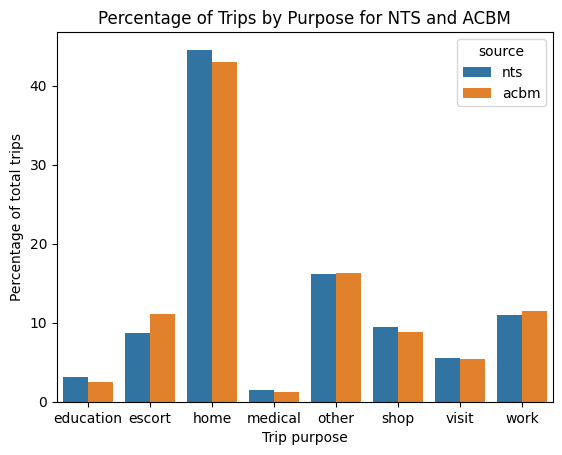

In [9]:
# Get number of trips by mode for legs_nts, and legs_acbm, and plot a comparative bar plot

# NTS
purpose_nts = legs_nts.groupby("dact").size().reset_index(name="count")
purpose_nts["source"] = "nts"

# ACBM
purpose_acbm = legs_acbm.groupby("dact").size().reset_index(name="count")
purpose_acbm["source"] = "acbm"

# Combine the data
purpose_compare = pd.concat([purpose_nts, purpose_acbm])

# Calculate the percentage of trips for each mode within each source
purpose_compare["percentage"] = purpose_compare.groupby("source")["count"].transform(lambda x: (x / x.sum()) * 100)


sns.barplot(data=purpose_compare, x="dact", y="percentage", hue="source")
plt.xlabel('Trip purpose')
plt.ylabel('Percentage of total trips')
plt.title('Percentage of Trips by Purpose for NTS and ACBM')
plt.show()

In [10]:
purpose_compare

,dact,count,source,percentage
0,education,1823,nts,3.071143
1,escort,5180,nts,8.726562
2,home,26434,nts,44.532421
3,medical,859,nts,1.447127
4,other,9628,nts,16.219950
5,shop,5621,nts,9.469499
6,visit,3313,nts,5.581293
7,work,6501,nts,10.952004
0,education,385,acbm,2.549162
1,escort,1684,acbm,11.150103


## Matching: Trip Mode 



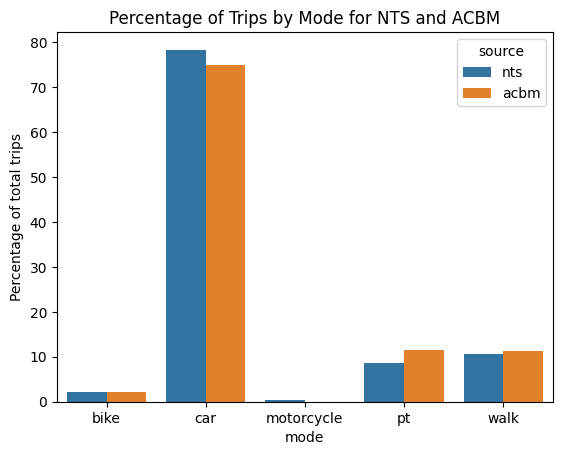

In [11]:
# Get number of trips by mode for legs_nts, and legs_acbm, and plot a comparative bar plot

# NTS
modeshare_nts = legs_nts.groupby("mode").size().reset_index(name="count")
modeshare_nts["source"] = "nts"

# ACBM
modeshare_acbm = legs_acbm.groupby("mode").size().reset_index(name="count")
modeshare_acbm["source"] = "acbm"

# Combine the data
modeshare_compare = pd.concat([modeshare_nts, modeshare_acbm])

# Calculate the percentage of trips for each mode within each source
modeshare_compare["percentage"] = modeshare_compare.groupby("source")["count"].transform(lambda x: (x / x.sum()) * 100)


sns.barplot(data=modeshare_compare, x="mode", y="percentage", hue="source")
plt.ylabel('Percentage of total trips')
plt.title('Percentage of Trips by Mode for NTS and ACBM')
plt.show()

## Matching: Time of Day 

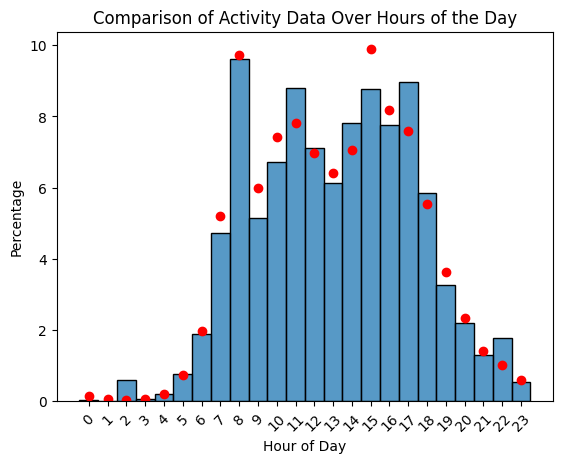

In [12]:
# Calculate the percentage of each hour in legs_acbm_clean['hour']
acbm_hour_counts = legs_acbm['tst_hour'].value_counts(normalize=True).sort_index() * 100

# Convert legs_nts["tst"] from minutes to hours
legs_nts['tst_hour'] = legs_nts['tst'] // 60

# Calculate the percentage of each hour in legs_nts['hour']
nts_hour_counts = legs_nts['tst_hour'].value_counts(normalize=True).sort_index() * 100

# Plot the histogram using seaborn
sns.histplot(legs_acbm['tst_hour'], bins=24, kde=False, discrete=True, stat='percent')
plt.xlabel('Hour of Day')
plt.ylabel('Percentage')
plt.title('Comparison of Activity Data Over Hours of the Day')
plt.xticks(range(0, 24), rotation=45)  # Set x-ticks to represent each hour of the day

# Add dots to represent the percentage values of legs_nts["tst"]
for hour, percent in nts_hour_counts.items():
    plt.plot(hour, percent, 'ro')  # 'ro' means red dot

plt.show()

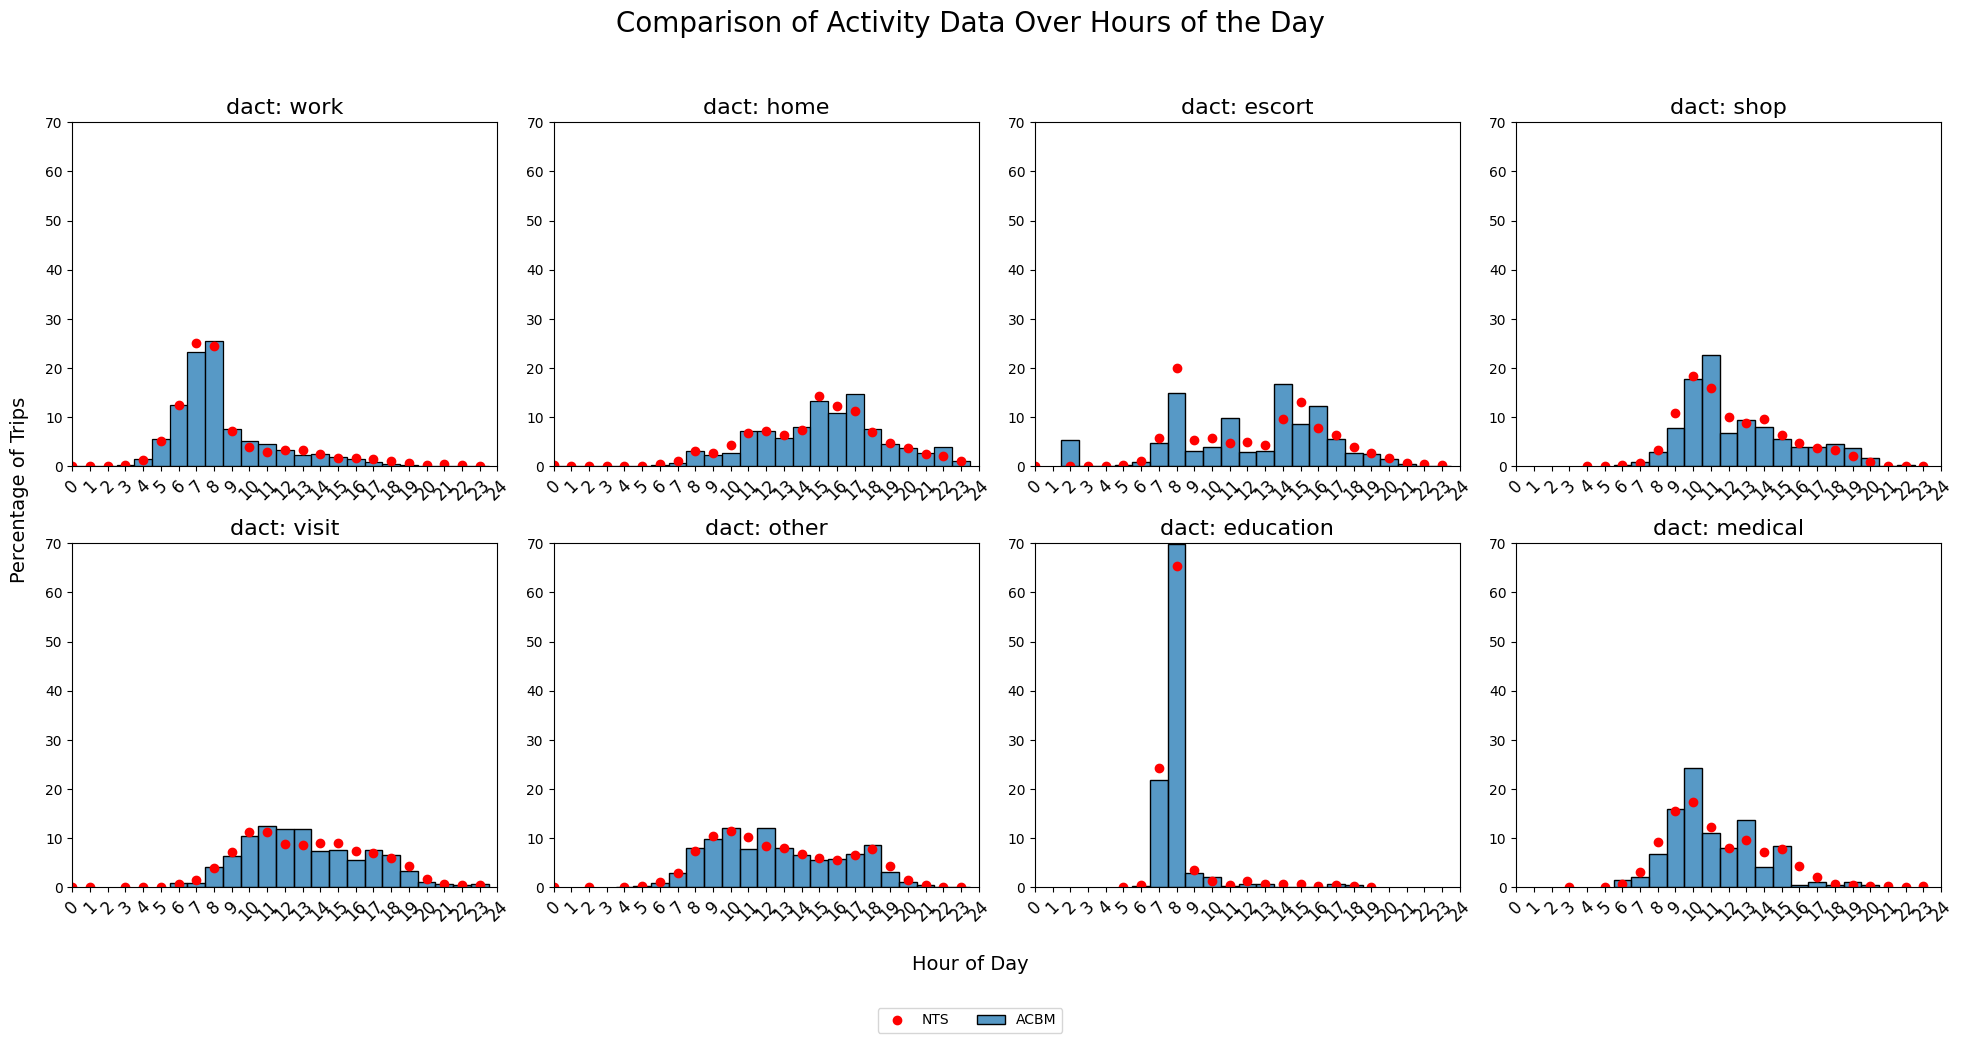

In [13]:
def plot_time_of_day_comparison(legs_acbm: pd.DataFrame, 
                                legs_nts: pd.DataFrame, 
                                activity_column: str = 'dact', 
                                hour_column: str = 'tst_hour', 
                                num_cols: int = 4, 
                                max_y_value: Optional[int] = None,
                                figsize: Optional[Tuple[int, int]] = (20, 5)) -> None:
    """
    Plots a comparison of activity data over the hours of the day for different activity types.

    Parameters
    ----------
    legs_acbm : pd.DataFrame
        DataFrame containing the ACBM data.
    legs_nts : pd.DataFrame
        DataFrame containing the NTS data.
    activity_column : str, optional
        The column name for the activity types. Default is 'dact'.
    hour_column : str, optional
        The column name for the hour values. Default is 'tst_hour'.
    num_cols : int, optional
        The number of columns for the subplots. Default is 4.
    max_y_value : int, optional
        The maximum value for the y-axis. Default is 100.
    figsize : tuple of int, optional
        The size of the figure. Default is (20, 5).

    Returns
    -------
    None
        This function generates and displays a plot but does not return any value.
    """
    # Get unique dact values
    unique_dact_values = legs_acbm[activity_column].unique()

    # Create a figure with subplots
    num_plots = len(unique_dact_values)
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(figsize[0], num_rows * figsize[1]), sharey=False)
    axes = axes.flatten()

    # Iterate over unique dact values and create plots
    for i, dact_value in enumerate(unique_dact_values):
        ax = axes[i]
        acbm_data = legs_acbm[legs_acbm[activity_column] == dact_value]
        nts_data = legs_nts[legs_nts[activity_column] == dact_value]

        # Plot histogram for acbm_data
        hist = sns.histplot(acbm_data[hour_column], bins=24, kde=False, discrete=True, stat='percent', ax=ax, label='ACBM')
        ax.set_xticks(range(0, 25))  # Set x-ticks to represent each hour of the day, including 24
        ax.set_xlim(0, 24)  # Ensure the x-axis covers the full range from 0 to 24
        if max_y_value:
            ax.set_ylim(0, max_y_value) # So that all the plots have the same y axis
        ax.set_title(f'dact: {dact_value}', fontsize=16)
        ax.tick_params(axis='x', rotation=45, labelsize=12)  # Rotate x-axis labels by 45 degrees

        # Remove individual subplot labels
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Add dots to represent the percentage values of legs_nts["hour"]
        nts_hour_counts = nts_data[hour_column].value_counts(normalize=True).sort_index() * 100
        line, = ax.plot(nts_hour_counts.index, nts_hour_counts.values, 'ro', label='NTS')  # 'ro' means red dot

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add a main legend at the bottom
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

    # Add a main title to the figure
    fig.suptitle('Comparison of Activity Data Over Hours of the Day', fontsize=20)

    # Add a single centered x-label and y-label
    fig.text(0.5, 0.02, 'Hour of Day', ha='center', fontsize=14)
    fig.text(0.02, 0.5, 'Percentage of Trips', va='center', rotation='vertical', fontsize=14)

    # Adjust layout to make room for the main title and labels
    plt.tight_layout(rect=[0.03, 0.05, 1, 0.95])
    plt.show()

# Example usage
plot_time_of_day_comparison(legs_acbm, legs_nts, max_y_value=70)

## Matching: Activity Sequences

Abbreviate values

In [14]:
# Abbreviate the column values 

# Mapping dictionary
activity_mapping = {
    'home': 'h',
    'other': 'o',
    'escort': 'e',
    'work': 'w',
    'shop': 'sh',
    'visit': 'v',
    'education': 'edu',
    'medical': 'm'
}

# Replace values in 'origin activity' and 'destination activity' columns
legs_acbm['oact_abr'] = legs_acbm['oact'].replace(activity_mapping)
legs_acbm['dact_abr'] = legs_acbm['dact'].replace(activity_mapping)

# Replace values in 'oact' and 'dact' columns

legs_nts['oact_abr'] = legs_nts['oact'].replace(activity_mapping)
legs_nts['dact_abr'] = legs_nts['dact'].replace(activity_mapping)


Create chains from data and count number of observations of each chain

In [15]:
import pandas as pd
from pandas import DataFrame

def process_sequences(df: DataFrame, 
                      pid_col: str, 
                      seq_col: str, 
                      origin_activity_col: str, 
                      destination_activity_col: str,
                      suffix: str) -> DataFrame:
    """
    Processes a DataFrame to generate activity sequences and counts the number of occurrences of each sequence.


    Parameters
    ----------
    df: pd.DataFrame
        The input DataFrame containing the data.
    pid_col: str
        The name of the column representing the unique identifier for each group.
    seq_col: str
        The name of the column representing the sequence order within each group.
    origin_activity_col: str
        The name of the column representing the origin activity.
    destination_activity_col: str
        The name of the column representing the destination activity.
    suffix: str
        The suffix to be added to the count column name.

    Returns
    -------
    pd.DataFrame
        A DataFrame with the activity sequences and their counts.
        
        activity_sequence           count_{suffix}
        ----------------------      --------------
        home - work - visit - home              5
        home - school - home                    3
        home - work - home                     20
    """
    # Step 1: Sort the DataFrame by 'pid' and 'seq'
    sorted_df = df.sort_values(by=[pid_col, seq_col])
    
    # Step 2: Group by 'pid' and concatenate 'origin activity' values followed by the last 'destination activity' value
    activity_sequence_df = sorted_df.groupby(pid_col).apply(
        lambda x: ' - '.join(x[origin_activity_col].tolist() + [x[destination_activity_col].iloc[-1]])
    ).reset_index()
    
    # Rename the columns for clarity
    activity_sequence_df.columns = [pid_col, 'activity_sequence']
    
    # Step 3: Group by the resulting 'activity_sequence' column and count the number of values in each group
    result = activity_sequence_df.groupby('activity_sequence').size().reset_index(name=f'count_{suffix}')    
    return result

In [16]:
sequence_nts = process_sequences(df = legs_nts, 
                                 pid_col = 'IndividualID', 
                                 seq_col = 'seq', 
                                 origin_activity_col = 'oact', 
                                 destination_activity_col = 'dact',
                                 suffix = 'nts')

sequence_nts

/tmp/ipykernel_753888/491085427.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  activity_sequence_df = sorted_df.groupby(pid_col).apply(


,activity_sequence,count_nts
0,education - education - education,4
1,education - education - education - home,1
2,education - education - education - home - oth...,1
3,education - escort,1
4,education - escort - home,2
...,...,...
1818,work - work - work - home - other - home - oth...,1
1819,work - work - work - home - work - work - home...,1
1820,work - work - work - shop - work,1
1821,work - work - work - work - home - home - home...,1


In [17]:
sequence_acbm = process_sequences(df = legs_acbm,
                                  pid_col = 'pid', 
                                  seq_col = 'seq', 
                                  origin_activity_col = 'oact', 
                                  destination_activity_col = 'dact', 
                                  suffix = 'acbm')

sequence_acbm
                                  

/tmp/ipykernel_753888/491085427.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  activity_sequence_df = sorted_df.groupby(pid_col).apply(


,activity_sequence,count_acbm
0,home - education,12
1,home - education - education - home,1
2,home - education - escort - home,7
3,home - education - escort - shop - home,1
4,home - education - home,281
...,...,...
486,home - work - work - work - work - home,3
487,home - work - work - work - work - home - othe...,1
488,home - work - work - work - work - home - work...,1
489,home - work - work - work - work - work - home,1


Plot the comparison

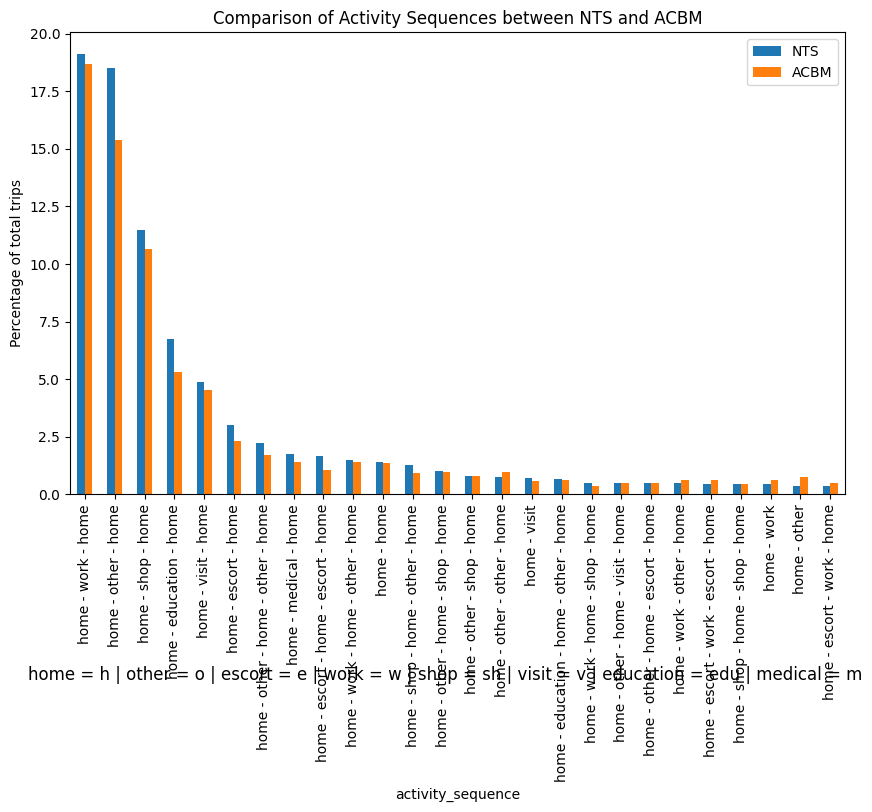

In [18]:
# join the two dataframes by 'activity_sequence'
sequence_nts_acbm = sequence_nts.merge(sequence_acbm, on='activity_sequence', how='inner').sort_values(by='count_nts', ascending=False)
sequence_nts_acbm

# Get % contribution of each unique activity sequence
sequence_nts_acbm['count_nts'] = sequence_nts_acbm['count_nts'] / sequence_nts_acbm['count_nts'].sum() * 100
sequence_nts_acbm['count_acbm'] = sequence_nts_acbm['count_acbm'] / sequence_nts_acbm['count_acbm'].sum() * 100

# Filter rows where both count columns are bigger than x %
x = 0.35

sequence_nts_acbm_filtered = sequence_nts_acbm[
    (sequence_nts_acbm['count_nts'] > x) & (sequence_nts_acbm['count_acbm'] > x)
]

# Plot the results as a bar chart
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

sequence_nts_acbm_filtered.plot(
    x='activity_sequence', 
    y=['count_nts', 'count_acbm'], 
    kind='bar', 
    ax=ax
)

plt.ylabel('Percentage of total trips')

plt.title('Comparison of Activity Sequences between NTS and ACBM')


# Generate custom legend
legend_labels = [f'{abbr} = {full}' for abbr, full in activity_mapping.items()]
custom_legend = ' | '.join(legend_labels)

# Add the custom legend to the plot
plt.legend(['NTS', 'ACBM'], loc='upper right')

# Add the custom legend below the chart
plt.figtext(0.5, -0.2, custom_legend, wrap=True, horizontalalignment='center', fontsize=12)

plt.show()


## Assigning: Trip distances

### Mean crowfly distance per trip purpose

Calculate travel distance for acbm activities

In [19]:
# TODO: add crs to config, and check other scripts

def calculate_distances(df: pd.DataFrame, 
                        start_wkt_col: str, 
                        end_wkt_col: str, 
                        crs_epsg: int = 4326, 
                        projected_epsg: int = 3857) -> pd.DataFrame:
    """
    Calculate distances between start and end geometries in a DataFrame.

    Parameters
    ----------

    df: pd.DataFrame
        DataFrame containing WKT geometry columns.
    start_wkt_col: str 
        Column name for start location WKT geometries.
    end_wkt_col: str
        Column name for end location WKT geometries.
    crs_epsg: int
        EPSG code for the original CRS (default is 4326 for WGS84).
    projected_epsg: int
        EPSG code for the projected CRS (default is 3857).

    Returns
    -------
    pd.DataFrame
        DataFrame with an additional 'distance' column containing distances in meters.
    """
        # Convert WKT strings to shapely geometries
    df['start_geometry'] = df[start_wkt_col].apply(wkt.loads)
    df['end_geometry'] = df[end_wkt_col].apply(wkt.loads)

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry='start_geometry')

    # Set the original CRS
    gdf.set_crs(epsg=crs_epsg, inplace=True)

    # Create a separate GeoDataFrame for the end geometries
    end_gdf = gdf.set_geometry('end_geometry')

    # Set the original CRS for the end_gdf
    end_gdf.set_crs(epsg=crs_epsg, inplace=True)

    # Transform both GeoDataFrames to a projected CRS
    gdf = gdf.to_crs(epsg=projected_epsg)
    end_gdf = end_gdf.to_crs(epsg=projected_epsg)

    # Calculate the distance between start and end geometries (in km)
    gdf['distance'] = round(gdf.geometry.distance(end_gdf.geometry) / 1000 , 1)

    return gdf

# Apply the function to legs_acbm_geo
legs_acbm_geo = calculate_distances(legs_acbm_geo, 'start_location_geometry_wkt', 'end_location_geometry_wkt')


In [20]:
legs_acbm_geo

,pid,hid,ozone,dzone,purp,oact,dact,mode,seq,tst,tet,duration,start_location_id,end_location_id,start_location_geometry_wkt,end_location_geometry_wkt,start_geometry,end_geometry,distance
0,200,89,E00059031,E00058877,work,home,work,car,1.0,1900-01-01 12:30:00,1900-01-01 13:00:00,0:30:00,1735597748,284127794,POINT (-1.399263822377326 53.934588245650026),POINT (-1.5223977194364153 53.80563634318617),POINT (-155765.336 7157777.811),POINT (-1.5223977194364153 53.80563634318617),27.9
1,200,89,E00059031,E00059031,home,work,home,car,2.0,1900-01-01 16:30:00,1900-01-01 17:00:00,0:30:00,284127794,1735597748,POINT (-1.5223977194364153 53.80563634318617),POINT (-1.399263822377326 53.934588245650026),POINT (-169472.539 7133431.742),POINT (-1.399263822377326 53.934588245650026),27.9
2,312,139,E00059045,E00057153,escort,home,escort,car,1.0,1900-01-01 06:35:00,1900-01-01 06:54:00,0:19:00,1750466246,1467798536,POINT (-1.4001307419061457 53.927941746853776),POINT (-1.4563558108534633 53.80668344951966),POINT (-155861.841 7156521.118),POINT (-1.4563558108534633 53.80668344951966),23.7
3,312,139,E00057153,E00169797,work,escort,work,car,2.0,1900-01-01 06:55:00,1900-01-01 07:22:00,0:27:00,1467798536,443167284,POINT (-1.4563558108534633 53.80668344951966),POINT (-1.5484560286132372 53.797016858417656),POINT (-162120.787 7133629.133),POINT (-1.5484560286132372 53.797016858417656),10.4
4,312,139,E00059045,E00059045,home,work,home,car,3.0,1900-01-01 18:00:00,1900-01-01 18:35:00,0:35:00,443167284,1750466246,POINT (-1.5484560286132372 53.797016858417656),POINT (-1.4001307419061457 53.927941746853776),POINT (-172373.337 7131807.059),POINT (-1.4001307419061457 53.927941746853776),29.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15098,794027,334502,E00057268,E00057826,home,visit,home,car,4.0,1900-01-01 22:30:00,1900-01-01 22:50:00,0:20:00,411620812,1238852478,POINT (-1.58002323810948 53.774918897587455),POINT (-1.5332742693848147 53.78164817605564),POINT (-175887.382 7127643.348),POINT (-1.5332742693848147 53.78164817605564),5.4
15099,794272,334647,E00170040,E00058459,shop,home,shop,car,1.0,1900-01-01 08:50:00,1900-01-01 09:00:00,0:10:00,156862474,13203295,POINT (-1.5323959656166048 53.7918310553218),POINT (-1.6721547587985188 53.81393394394979),POINT (-170585.539 7130829.750),POINT (-1.6721547587985188 53.81393394394979),16.1
15100,794272,334647,E00058459,E00170040,home,shop,home,car,2.0,1900-01-01 10:20:00,1900-01-01 10:30:00,0:10:00,13203295,156862474,POINT (-1.6721547587985188 53.81393394394979),POINT (-1.5323959656166048 53.7918310553218),POINT (-186143.416 7134996.069),POINT (-1.5323959656166048 53.7918310553218),16.1
15101,794273,334647,E00170040,E00057187,shop,home,shop,car,1.0,1900-01-01 08:50:00,1900-01-01 09:00:00,0:10:00,156862474,892243500,POINT (-1.5323959656166048 53.7918310553218),POINT (-1.4702034760278457 53.80747028988714),POINT (-170585.539 7130829.750),POINT (-1.4702034760278457 53.80747028988714),7.5


Plot the distance comparison

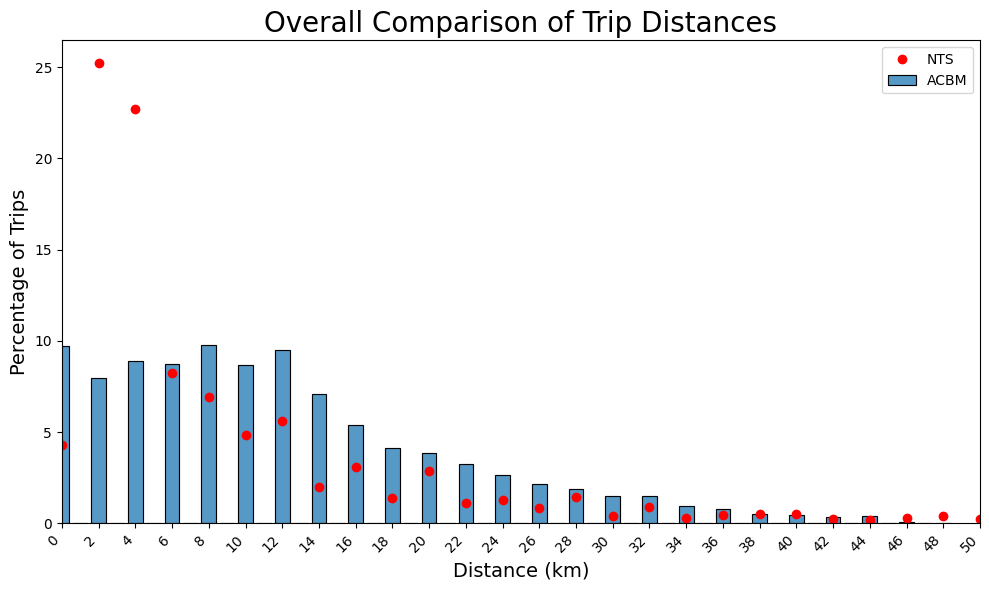

In [21]:

# Parameters
distance_column = 'distance'
bin_size = 2
distance_threshold = 50  # Set this to None if you don't want to use a threshold

# Create distance_binned column
legs_acbm_geo['distance_binned'] = (legs_acbm_geo[distance_column] / bin_size).round() * bin_size
legs_nts['distance_binned'] = (legs_nts[distance_column] / bin_size).round() * bin_size

# Define the bins
max_distance_data = max(legs_acbm_geo['distance_binned'].max(), legs_nts['distance_binned'].max())
if distance_threshold is not None:
    max_distance = min(distance_threshold, max_distance_data)
else:
    max_distance = max_distance_data
bins = range(0, int(max_distance) + bin_size, bin_size)

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram for legs_acbm_geo data
sns.histplot(legs_acbm_geo['distance_binned'], bins=bins, kde=False, discrete=True, stat='percent', ax=ax, label='ACBM', shrink=0.8)

# Add dots to represent the percentage values of legs_nts["distance_binned"]
nts_distance_counts = legs_nts['distance_binned'].value_counts(normalize=True).sort_index() * 100
if not nts_distance_counts.empty:
    bin_centers = nts_distance_counts.index
    ax.plot(bin_centers, nts_distance_counts.values, 'ro', label='NTS')  # 'ro' means red dot

# Set x-axis limits based on max_distance
ax.set_xlim(0, max_distance)
# Add x-axis ticks and labels for each bar
ax.set_xticks(bins)
ax.set_xticklabels([str(bin) for bin in bins], rotation=45, ha='right')


# Add labels and title
ax.set_xlabel('Distance (km)', fontsize=14)
ax.set_ylabel('Percentage of Trips', fontsize=14)
ax.set_title('Overall Comparison of Trip Distances', fontsize=20)
ax.legend()

# Adjust layout to make room for the main title and labels
plt.tight_layout()
plt.show()

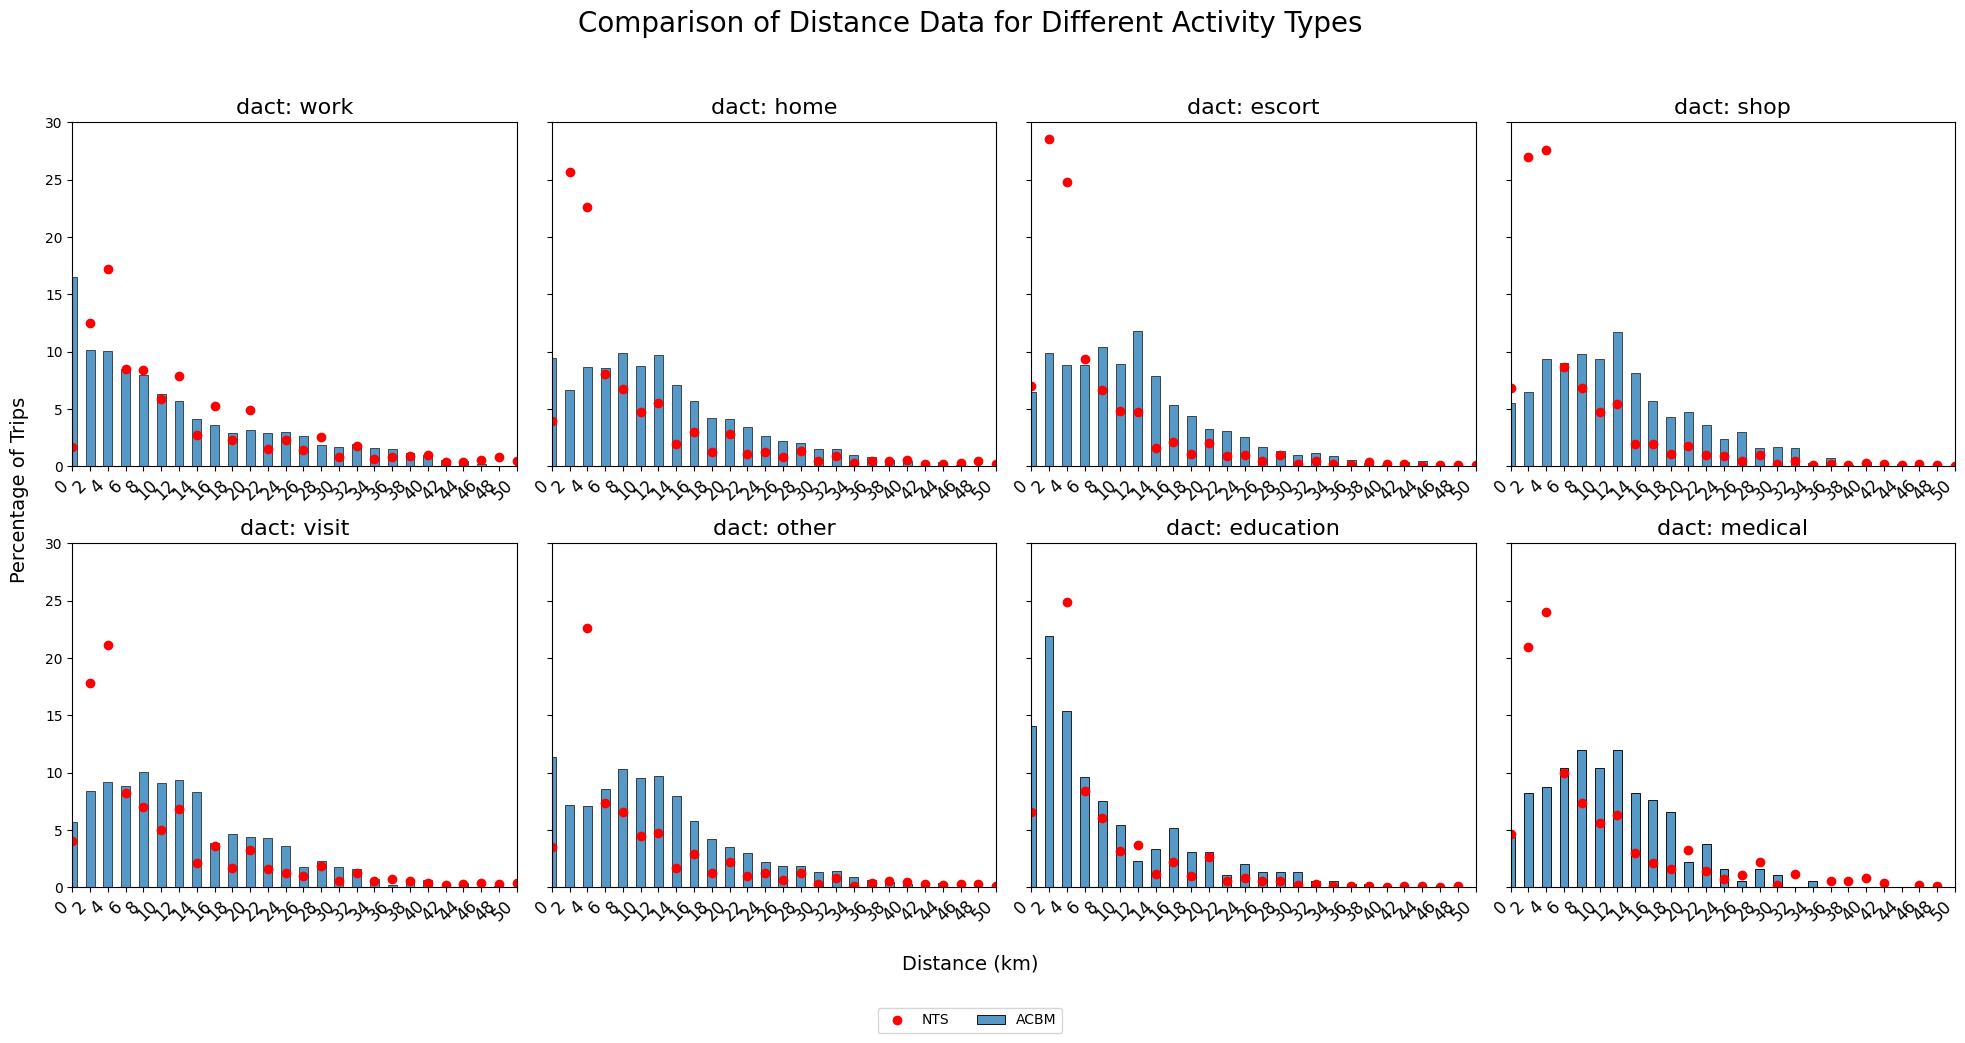

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import Optional, Tuple

def plot_distance_comparison(legs_acbm: pd.DataFrame, 
                             legs_nts: pd.DataFrame, 
                             activity_column: str = 'dact', 
                             distance_column: str = 'distance', 
                             bin_size: int = 2, 
                             num_cols: int = 4, 
                             max_y_value: int = 100,
                             figsize: Tuple[int, int] = (20, 5),
                             distance_threshold: Optional[int] = None) -> None:
    """
    Plots a comparison of distance data for different activity types.

    Parameters
    ----------
    legs_acbm : pd.DataFrame
        DataFrame containing the ACBM data.
    legs_nts : pd.DataFrame
        DataFrame containing the NTS data.
    activity_column : str, optional
        The column name for the activity types. Default is 'dact'.
    distance_column : str, optional
        The column name for the distance values. Default is 'distance'.
    bin_size : int, optional
        The size of the bins for rounding distances. Default is 2 km.
    num_cols : int, optional
        The number of columns for the subplots. Default is 4.
    max_y_value : int, optional
        The maximum value for the y-axis. Default is 100.
    figsize : tuple of int
        The size of the figure. Default is (20, 5).
    distance_threshold : int, optional
        The maximum value for the x-axis. Default is None.

    Returns
    -------
    None
        This function generates and displays a plot but does not return any value.
    """
    # Create distance_binned column
    legs_acbm['distance_binned'] = (legs_acbm[distance_column] / bin_size).round() * bin_size
    legs_nts['distance_binned'] = (legs_nts[distance_column] / bin_size).round() * bin_size

    # Define the bins
    max_distance_data = max(legs_acbm['distance_binned'].max(), legs_nts['distance_binned'].max())
    if distance_threshold is not None:
        max_distance = min(distance_threshold, max_distance_data)
    else:
        max_distance = max_distance_data
    bins = range(0, int(max_distance) + bin_size, bin_size)

    # Get unique dact values
    unique_dact_values = legs_acbm[activity_column].unique()

    # Create a figure with subplots
    num_plots = len(unique_dact_values)
    num_rows = (num_plots + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(figsize[0], num_rows * figsize[1]), sharey=True)
    axes = axes.flatten()

    # Iterate over unique dact values and create plots
    for i, dact_value in enumerate(unique_dact_values):
        ax = axes[i]
        acbm_data = legs_acbm[legs_acbm[activity_column] == dact_value]
        nts_data = legs_nts[legs_nts[activity_column] == dact_value]

        # Plot histogram for acbm_data
        hist = sns.histplot(acbm_data['distance_binned'], bins=bins, kde=False, discrete=True, stat='percent', ax=ax, label='ACBM')
        ax.set_title(f'dact: {dact_value}', fontsize=16)
        ax.tick_params(axis='x', rotation=45, labelsize=12)  # Rotate x-axis labels by 45 degrees

        # Set x-axis limits based on max_distance
        ax.set_xlim(0, max_distance)
        # Set y-axis limits based on max_y_value
        ax.set_ylim(0, max_y_value)

        # Add x-axis ticks and labels for each bar
        ax.set_xticks(bins)
        ax.set_xticklabels([str(bin) for bin in bins], rotation=45, ha='right')

        # Remove individual subplot labels
        ax.set_xlabel('')
        ax.set_ylabel('')

        # Add dots to represent the percentage values of legs_nts["distance_binned"]
        nts_distance_counts = nts_data['distance_binned'].value_counts(normalize=True).sort_index() * 100
        if not nts_distance_counts.empty:
            bin_centers = nts_distance_counts.index
            ax.plot(bin_centers, nts_distance_counts.values, 'ro', label='NTS')  # 'ro' means red dot

    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Add a main legend at the bottom
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05))

    # Add a main title to the figure
    fig.suptitle('Comparison of Distance Data for Different Activity Types', fontsize=20)

    # Add a single centered x-label and y-label
    fig.text(0.5, 0.02, 'Distance (km)', ha='center', fontsize=14)
    fig.text(0.02, 0.5, 'Percentage of Trips', va='center', rotation='vertical', fontsize=14)

    # Adjust layout to make room for the main title and labels
    plt.tight_layout(rect=[0.03, 0.05, 1, 0.95])
    plt.show()

# Example usage
plot_distance_comparison(legs_acbm_geo, legs_nts, distance_threshold=50, max_y_value=30)

### Test number of intrazonal trips

To ensure that our intrazonal logic is working. It appears we are underestimating the number of trips that are 2-4km and 4-6km. 

This could also be a result of travel times not correlating directly with distance, and that effect being more pronounced in shorter trips.


In [23]:
# add binary column to identify intrazonal trips
legs_acbm['intrazonal'] = legs_acbm['ozone'] == legs_acbm['dzone']


        purp  total_count  intrazonal_count  percentage
0  education          385                 2    0.519481
1     escort         1684                16    0.950119
2       home         6498               399    6.140351
3    medical          189                 2    1.058201
4      other         2457               115    4.680505
5       shop         1337                24    1.795064
6      visit          816                15    1.838235
7       work         1737                77    4.432930


/tmp/ipykernel_753888/3001768473.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=merged_counts, x='purp', y='percentage', palette='viridis')


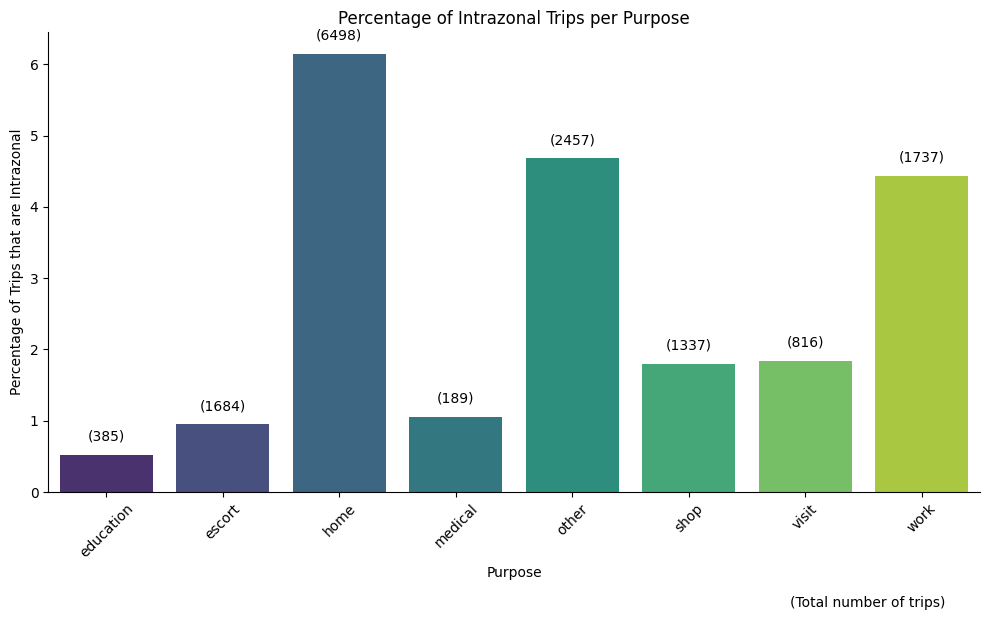

In [24]:
# Total number of trips per trip purpose
total_counts = legs_acbm.groupby('purp').size().reset_index(name='total_count')

# Filter the DataFrame to include only rows where intrazonal_trips is TRUE
intrazonal_trips_true = legs_acbm[legs_acbm['intrazonal'] == True]

# Total number of intrazonal trips per trip purpose
intrazonal_counts = intrazonal_trips_true.groupby('purp').size().reset_index(name='intrazonal_count')

# Merge the two DataFrames and calculate intrazonal %
merged_counts = pd.merge(total_counts, intrazonal_counts, on='purp', how='left')
# Fill NaN values with 0 (in case there are purp groups with no intrazonal trips)
merged_counts['intrazonal_count'] = merged_counts['intrazonal_count'].fillna(0)
# Calculate the percentage of intrazonal trips
merged_counts['percentage'] = (merged_counts['intrazonal_count'] / merged_counts['total_count']) * 100

# Print the resulting DataFrame
print(merged_counts)

# Create the bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=merged_counts, x='purp', y='percentage', palette='viridis')
plt.title('Percentage of Intrazonal Trips per Purpose')
plt.xlabel('Purpose')
plt.ylabel('Percentage of Trips that are Intrazonal')
plt.xticks(rotation=45)

# Add text annotations above each bar
for index, row in merged_counts.iterrows():
    barplot.text(index, row['percentage'] + 0.2, f"({int(row['total_count'])})", color='black', ha="center")

# Remove the top and right spines (box frame) from the plot
barplot.spines['top'].set_visible(False)
barplot.spines['right'].set_visible(False)



# Add footnote on the right below the plot
plt.figtext(0.95, -0.02, '(Total number of trips)', ha='right', fontsize=10)

plt.tight_layout()
plt.show()

Let's look at OD pairs. We can then distinguish between primary and secondary trips when considering intrazonal trips. This is useful because the logic for assigning trips to zones is different for primary and secondary trips. It is also different between home-work and home-education trips (both primary)

                  od  trip_type  total_count  intrazonal_count  percentage
32     other - other  secondary          181              24.0   13.259669
53       work - home    primary         1399             152.0   10.864904
2   education - home    primary          339              35.0   10.324484
18      home - other  secondary         1961              79.0    4.028557
31      other - home  secondary         1866              74.0    3.965702
8      escort - home  secondary         1004              14.0    1.394422
20      home - visit  secondary          563               7.0    1.243339
21       home - work    primary         1451              18.0    1.240524
17    home - medical  secondary          167               2.0    1.197605
45      visit - home  secondary          530               6.0    1.132075
19       home - shop  secondary         1052              11.0    1.045627
7    escort - escort  secondary          292               3.0    1.027397
37       shop - home  sec

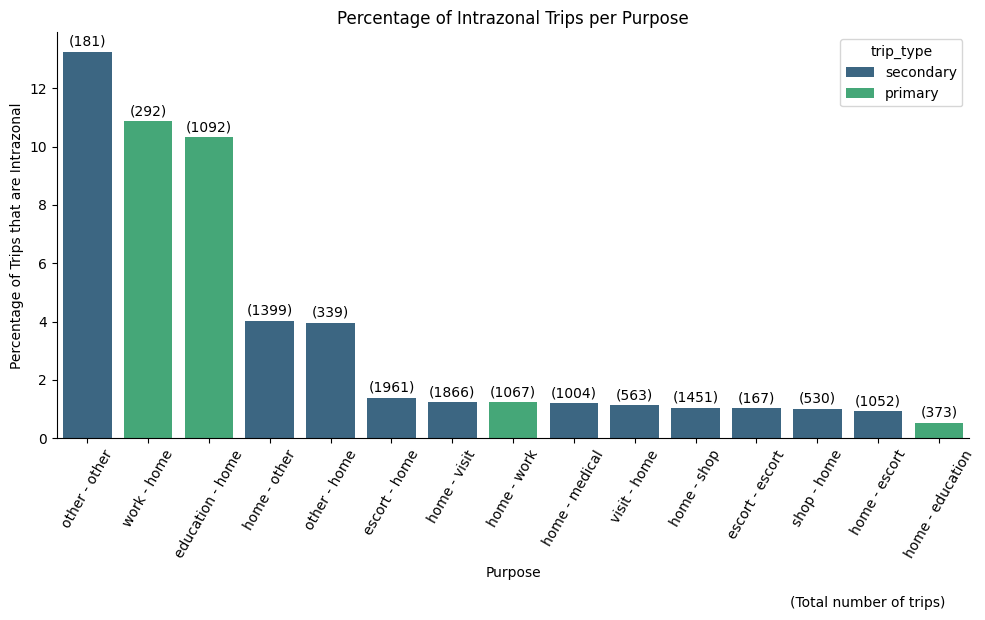

In [31]:
# Add the trip_type column
conditions_primary = (
    ((legs_acbm['oact'] == 'home') & (legs_acbm['dact'].isin(['work', 'education']))) |
    ((legs_acbm['oact'].isin(['work', 'education'])) & (legs_acbm['dact'] == 'home'))
)
legs_acbm['trip_type'] = np.where(conditions_primary, 'primary', 'secondary')

# Filter all trips where oact is home and dact is work or education
# legs_acbm_primary = legs_acbm[(legs_acbm['oact'] == 'home') & ((legs_acbm['dact'] == 'work') | (legs_acbm['dact'] == 'education'))]
legs_acbm_primary = legs_acbm.copy()

# Create an od column to identify the origin-destination pairs
legs_acbm_primary['od'] = legs_acbm_primary['oact'] + ' - ' + legs_acbm_primary['dact']

# Total number of trips per trip purpose
total_counts = legs_acbm_primary.groupby(['od', 'trip_type']).size().reset_index(name='total_count')

# Filter the DataFrame to include only rows where intrazonal_trips is TRUE
intrazonal_trips_true = legs_acbm_primary[legs_acbm_primary['intrazonal'] == True]

# Total number of intrazonal trips per trip purpose
intrazonal_counts = intrazonal_trips_true.groupby(['od', 'trip_type']).size().reset_index(name='intrazonal_count')

# Merge the two DataFrames and calculate intrazonal %
merged_counts = pd.merge(total_counts, intrazonal_counts, on=['od', 'trip_type'], how='left')
# Fill NaN values with 0 (in case there are od groups with no intrazonal trips)
merged_counts['intrazonal_count'] = merged_counts['intrazonal_count'].fillna(0)
# Calculate the percentage of intrazonal trips
merged_counts['percentage'] = (merged_counts['intrazonal_count'] / merged_counts['total_count']) * 100
# Keep top 15 od pairs
merged_counts = merged_counts.sort_values(by='total_count', ascending=False).head(15)

# Sort by percentage before plotting
merged_counts = merged_counts.sort_values(by='percentage', ascending=False)

# Print the resulting DataFrame
print(merged_counts)

# Create the bar plot
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=merged_counts, x='od', y='percentage', hue='trip_type', palette='viridis')
plt.title('Percentage of Intrazonal Trips per Purpose')
plt.xlabel('Purpose')
plt.ylabel('Percentage of Trips that are Intrazonal')
plt.xticks(rotation=60)

# Add text annotations above each bar
for bar, row in zip(barplot.patches, merged_counts.iterrows()):
    barplot.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f"({int(row[1]['total_count'])})", color='black', ha="center")

# Remove the top and right spines (box frame) from the plot
barplot.spines['top'].set_visible(False)
barplot.spines['right'].set_visible(False)

# Add footnote on the right below the plot
plt.figtext(0.95, -0.02, '(Total number of trips)', ha='right', fontsize=10)

plt.tight_layout()
plt.show()

TODO: Remove later

Check if total trips FROM and TO each activity are the same


In [48]:
# ACBM: Check if total trips FROM and TO each activity are the same

# Group by 'oact' and and calculate the total number of trips
total_trips_from = legs_acbm.groupby(['oact']).size().reset_index(name='total_trips_from')
# rename oact to activity
total_trips_from = total_trips_from.rename(columns={'oact': 'activity'})
total_trips_from

# Group by 'dact' and and calculate the total number of trips
total_trips_to = legs_acbm.groupby(['dact']).size().reset_index(name='total_trips_to')
# rename dact to activity
total_trips_to = total_trips_to.rename(columns={'dact': 'activity'})

# Merge the two DataFrames
total_trips = pd.merge(total_trips_from, total_trips_to, on='activity', how='outer')

total_trips


,activity,total_trips_from,total_trips_to
0,education,373,385
1,escort,1673,1684
2,home,6752,6498
3,medical,183,189
4,other,2389,2457
5,shop,1318,1337
6,visit,716,816
7,work,1699,1737


In [57]:
# NTS: Check if total trips FROM and TO each activity are the same

# Group by 'oact' and and calculate the total number of trips
total_trips_from = legs_nts.groupby(['oact']).size().reset_index(name='total_trips_from')
# rename oact to activity
total_trips_from = total_trips_from.rename(columns={'oact': 'activity'})
total_trips_from

# Group by 'dact' and and calculate the total number of trips
total_trips_to = legs_nts.groupby(['dact']).size().reset_index(name='total_trips_to')
# rename dact to activity
total_trips_to = total_trips_to.rename(columns={'dact': 'activity'})

# Merge the two DataFrames
total_trips = pd.merge(total_trips_from, total_trips_to, on='activity', how='outer')

total_trips

,activity,total_trips_from,total_trips_to
0,education,1796,1823
1,escort,5158,5180
2,home,26573,26434
3,medical,850,859
4,other,9610,9628
5,shop,5633,5621
6,visit,3212,3313
7,work,6527,6501


### Crowfly distance cumulative chart (KM distance vs. % of trips)